<a href="https://colab.research.google.com/github/dmartmillan/DeepLearningSpotNuclei/blob/main/template_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import keras.backend as K
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')
# data_loc = '/content/gdrive/My Drive/data'
data_loc = './data'
from data_processing import data_grinder

seed = 2023
np.random.seed(seed)  

## 0. Some functions

In [2]:
def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('IoU')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IoU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IoU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

def iou(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        return iou
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

def diceloss(y_true, y_pred, smooth=1e-6):
    
    #flatten label and prediction tensors
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred))
        dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
        return 1 - dice

## 1. Load images

In [3]:
import pickle
data_set = open(f'{data_loc}/data_set.obj', 'rb')
data_dict = pickle.load(data_set)
data_set.close()
train_dict = data_dict['train_dict']
val_dict = data_dict['val_dict']
test_dict = data_dict['test_dict']
data_dict.clear()

## 2. Pre-processing

### 2.1 Procedure

In [4]:
train_set = data_grinder(train_dict)
val_set = data_grinder(val_dict)
train_set.preprocessImages()
val_set.preprocessImages()

2023-05-12 20:48:48.727676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-05-12 20:48:48.736820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78997 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


### 2.2 Display images

Image, processed image and mask from data set No. 533 with size (360, 360): c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


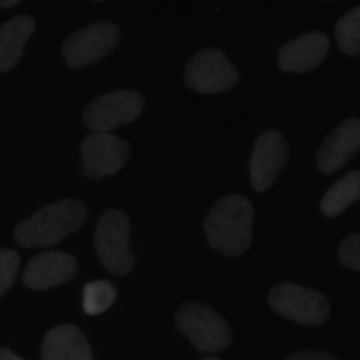

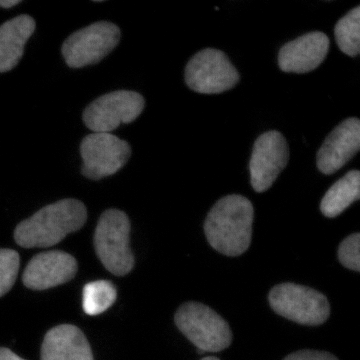

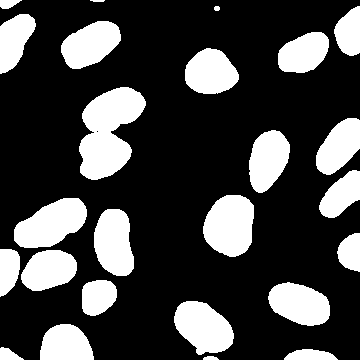

In [5]:
# display
train_set.display_imgs(ix0= 533) # without ix0 input, it will give a random index

## 3. Pre-processing

In [6]:
train_set.croporresizeImages()
val_set.croporresizeImages()

### 3.2 Display images

Processed image and mask from train set No. 208 with size (256, 256): 4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32


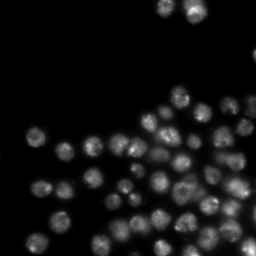

It crops to 4 masks with size (128, 128, 1)
cropped image and mask: 1


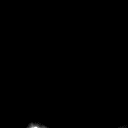

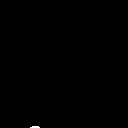

cropped image and mask: 2


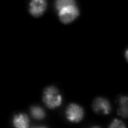

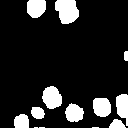

cropped image and mask: 3


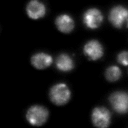

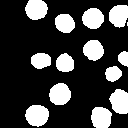

cropped image and mask: 4


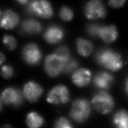

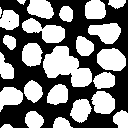

In [7]:
# display
train_set.display_crops() # without ix0 input, it will give a random index

## 4. Test the rejoin function

Image and mask from data set No. 154 with size (256, 256): 3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff
Original image


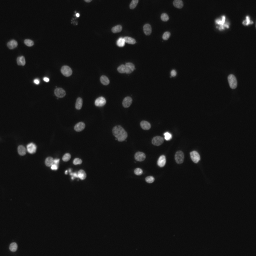

Processed image


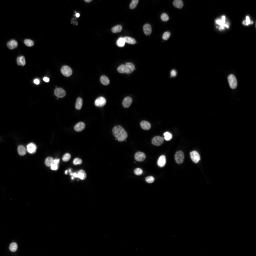

Original mask


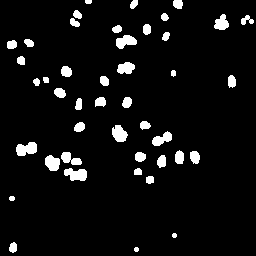

Rejoined mask


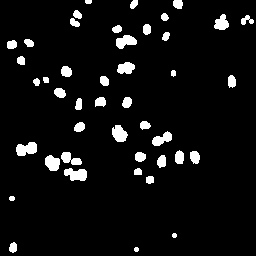

In [8]:
Y_pred_train = train_dict['Y']
train_set.rejoinMask(Y_pred_train)
train_set.display_rejoinmasks() # without ix0 input, it will give a random index

## 5. Transfer Learning Model (Efficientnet)

### 5.1 Prepare data

In [9]:
train_set.list2array()
val_set.list2array()
X_train0, Y_train = train_set.data_dict['X_array'], train_set.data_dict['Y_array']
X_val0, Y_val = val_set.data_dict['X_array'], val_set.data_dict['Y_array']

X_train = tf.keras.applications.efficientnet.preprocess_input(X_train0)
X_val = tf.keras.applications.efficientnet.preprocess_input(X_val0)
print(f'X_train shape:, {X_train.shape}; Y_train shape:, {Y_train.shape}')
print(f'X_val shape:, {X_val.shape}; Y_val shape:, {Y_val.shape}')

X_train shape:, (7315, 128, 128, 3); Y_train shape:, (7315, 128, 128, 1)
X_val shape:, (812, 128, 128, 3); Y_val shape:, (812, 128, 128, 1)


### 5.2 Model setup

In [10]:
# Encoder

base_model = tf.keras.applications.EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.summary()
print(str(base_model.get_layer(index=1)))

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 4, 4, 192)    221184      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 4, 4, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 4, 4, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 4, 4, 192)    0           ['block6b_drop[0][0]',           
          

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def create_model(input_shape):
    inputs = Input(input_shape)
    
    efficientnetB0 = tf.keras.applications.EfficientNetB0(input_shape=input_shape, input_tensor=inputs, include_top=False, weights='imagenet')
    efficientnetB0.trainable = False
    
    s1 = efficientnetB0.get_layer(index=0).output                        # 128x128
    s2 = efficientnetB0.get_layer('block2a_expand_activation').output    # 64x64
    s3 = efficientnetB0.get_layer('block3a_expand_activation').output    # 32x32
    s4 = efficientnetB0.get_layer('block4a_expand_activation').output    # 16x16
    
    print(s1.shape, s2.shape, s3.shape, s4.shape)
    
    b1 = efficientnetB0.get_layer('block6a_expand_activation').output   # 8x8
    
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs)

    return (model, efficientnetB0)

### 5.3 Parameters

In [12]:
epochs = 20
batch_size = 32
LR = 0.001
input_shape = (128,128,3)
#early_stopping = EarlyStopping(patience=10, verbose=1)
#model_checkpoint = ModelCheckpoint(f"{data_loc}/keras.model", save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

model, efficientnetB0 = create_model(input_shape)
model.compile(optimizer=Adam(learning_rate=LR),loss=diceloss, metrics=[mean_iou])
model.summary()

(None, 128, 128, 3) (None, 64, 64, 96) (None, 32, 32, 144) (None, 16, 16, 240)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 128, 128, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
               

### 5.4 Training

In [13]:
save_path = "./data/efficientnetB0-initial-test"
if not os.path.exists(save_path):
    os.mkdir(save_path)

Note: No early stopping because validation set is too small

In [14]:
history = model.fit(X_train, Y_train,
                    validation_data=[X_val, Y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    shuffle=True)

Epoch 1/20


2023-05-12 20:50:52.509106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


229/229 [==============================] - 33s 47ms/step - loss: 0.1459 - mean_iou: 0.8065 - val_loss: 0.2341 - val_mean_iou: 0.6821
Epoch 2/20
229/229 [==============================] - 9s 39ms/step - loss: 0.0783 - mean_iou: 0.8447 - val_loss: 0.2232 - val_mean_iou: 0.6852
Epoch 3/20
229/229 [==============================] - 9s 39ms/step - loss: 0.0735 - mean_iou: 0.8474 - val_loss: 0.2021 - val_mean_iou: 0.6421
Epoch 4/20
229/229 [==============================] - 9s 40ms/step - loss: 0.0697 - mean_iou: 0.8555 - val_loss: 0.1978 - val_mean_iou: 0.7139
Epoch 5/20
229/229 [==============================] - 9s 40ms/step - loss: 0.0673 - mean_iou: 0.8602 - val_loss: 0.1999 - val_mean_iou: 0.7141
Epoch 6/20
229/229 [==============================] - 9s 39ms/step - loss: 0.0652 - mean_iou: 0.8635 - val_loss: 0.2223 - val_mean_iou: 0.6916
Epoch 7/20
229/229 [==============================] - 9s 39ms/step - loss: 0.0646 - mean_iou: 0.8653 - val_loss: 0.1839 - val_mean_iou: 0.7351
Epoch 8/2

Training set IoU: 0.8877
Training set Loss:0.061143

Validation set IoU: 0.7482
Validation set Loss:0.170935



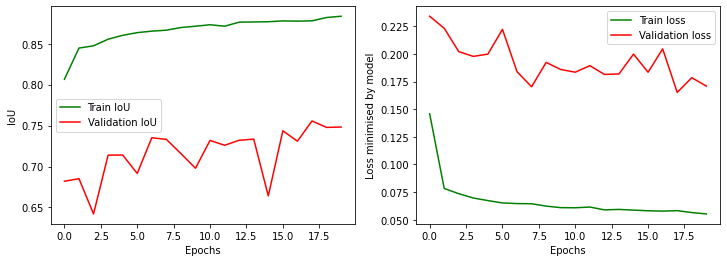

In [15]:
[train_loss, train_IoU] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_IoU] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(history)
plt.savefig(f"{save_path}/history_plots.png")

### 5.5 Fine Tuning

In [ ]:
# Unfreeze encoder
efficientnetB0.trainable = True

# Recompile model with low LR
LR = 1e-5
model.compile(optimizer=Adam(learning_rate=LR),loss=diceloss, metrics=[mean_iou])
model.summary()

In [ ]:
# half the epochs to stop overfitting
history = model.fit(X_train, Y_train,
                    validation_data=[X_val, Y_val], 
                    epochs=int(epochs/2),
                    batch_size=batch_size,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    shuffle=True)

In [ ]:
[train_loss, train_IoU] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_IoU] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(history)
plt.savefig(f"{save_path}/history_plots-fine_tuning.png")

In [16]:
model.save(save_path)

2023-05-12 20:55:58.281410: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./data/efficientnetB0-initial-test/assets


/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/apps/gent/RHEL8/zen3-ampere-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### 5.5 Model evaluation

In [35]:
# optional load model
#model = tf.keras.models.load_model("./data/efficientnetB7-initial-test", custom_objects = {"mean_iou": mean_iou, "diceloss": diceloss})

In [17]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

26/26 [==============================] - 0s 14ms/step


Image


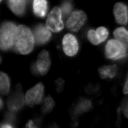

Mask


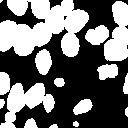

Prediction


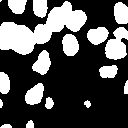

Difference


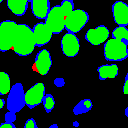

412


In [31]:
ix = random.randint(0, len(preds_val_t))
ix = 412
print("Image")
display(keras.preprocessing.image.array_to_img(X_val0[ix]*255))
print("Mask")
display(keras.preprocessing.image.array_to_img(Y_val[ix]))
print("Prediction")
display(keras.preprocessing.image.array_to_img(preds_val_t[ix]))
print("Difference")
x = np.zeros((128, 128, 3), dtype=np.uint8)
x[:,:,0] = ((1 - Y_val[ix]*1) * (preds_val_t[ix]*1))[:,:,0] # wrongly predicted in red
x[:,:,1] = ((Y_val[ix]*1) * (preds_val_t[ix]*1))[:,:,0] # correctly predicted in green
x[:,:,2] = ((Y_val[ix]*1) * (1 - preds_val_t[ix]*1))[:,:,0] # not predicted in blue
display(keras.preprocessing.image.array_to_img(x))
print(ix)

### 5.6 Calculate IoU for Validation set

In [19]:
train_set.rejoinMask(preds_train)
val_set.rejoinMask(preds_val)

train_set.cal_iou()
print("Train set IoU:{:7.4f}".format(train_set.mean_iou))
val_set.cal_iou()
print("Validation set IoU:{:7.4f}".format(val_set.mean_iou))

Train set IoU: 0.8706
Validation set IoU: 0.7655


### 5.7 Test evaluation (to be updated)

In [ ]:
test_set = data_grinder(test_dict)
test_set.preprocessImages()
test_set.croporresizeImages(hasmask = False)
test_set.list2array()
X_test0 = test_set.data_dict['X_array']

X_test = X_test0[:,:,:,0]/255 # standardization

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
test_set.rejoinMask(preds_test)

1335/1335 [==============================] - 33s 25ms/step


In [ ]:
imageIDs = test_set.data_dict['imageIDs']
ix = random.randint(0, len(imageIDs) - 1)
display(test_set.data_dict['images'][ix])
display(test_set.data_dict['cal_masks'][ix])

## 6. Export to EXCEL